# Real-time Image Smoothing via Iterative Least Squares




## Import needed libraries

In [26]:
from __future__ import division            # forces floating point division 
import numpy as np                          # Numerical Python 
import matplotlib.pyplot as plt             # Python plotting
from PIL import Image                       # Python Imaging Library
from numpy.fft import fft2, fftshift, ifft2 # Python DFT
import cv2


# Show plots in the notebook (don't use it in Python scripts)
%matplotlib inline 


## Load and show Original Image

PNG
(1024, 768)
RGB


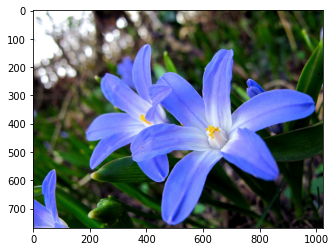

In [2]:
# load and show an image with Pillow
# Open the image form working directory
image = Image.open('flower.png')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image in external windown
# image.show()
plt.imshow(np.asarray(image))


## Apply Weighted average based method (gaussian_filter)

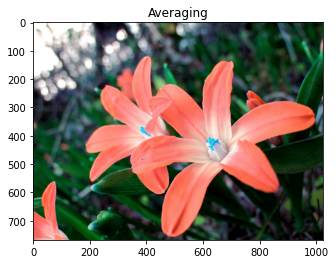

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('flower.png')
kernel = np.ones((5,5),np.float32)/25
dst = cv.filter2D(img,-1,kernel)
plt.imshow(img),plt.title('Averaging')
plt.show()


## Real-time Image Smoothing via Iterative Least Squares Algorithm

## FFT , IFFT

In [5]:
# point spread function (PSF) is impulse response, describes the response of an imaging system to a point source or point object.
# optical transfer function (OTF) is defined as the Fourier transform of the point spread function 
# ---------------------------------------------------------------------

def psf2otf_Dx(outSize):
    psf = np.zeros(outSize)
    psf[0, 0] = -1
    psf[0, :] = 1
    otf = fft2(psf)
    return otf


def psf2otf_Dy(outSize):
    psf = np.zeros(outSize)
    psf[0, 0] = -1
    psf[:, 0] = 1
    otf = fft2(psf)
    return otf



In [6]:
#Input 
lam = 1
k = 4
p = 0.8
eps = 0.0001
gamma = 0.5 * p - 1
c =  p * eps**gamma
image = Image.open('flower.png')
f = np.asarray(image)
N, M, D = f.shape # (768, 1024, 3)
sizeI2D = [N, M]
sizeI2D

[768, 1024]

In [7]:
# pre-compute
otfFx = psf2otf_Dx(sizeI2D)
otfFy = psf2otf_Dy(sizeI2D)
print(otfFx.shape)
print(otfFy.shape)

(768, 1024)
(768, 1024)


In [13]:
# import numpy.matlib
Denormin = abs(otfFx)**2 + abs(otfFy )**2
Denormin = Denormin[:,:, np.newaxis]
# # matlib.repmat(a, m, n)[source] Repeat a 0-D to 2-D array or matrix MxN times.
Denormin = np.repeat(Denormin, D, axis=2) #np.matlib.repmat(Denormin, N, M)

denominator = 1 + 0.5 * c * lam * Denormin
denominator.shape
denominator[0,1,0]


59262837.10314825

In [15]:
denominator[0,1,1]


59262837.10314825

In [16]:
U = f
normin1 = fft2(U)


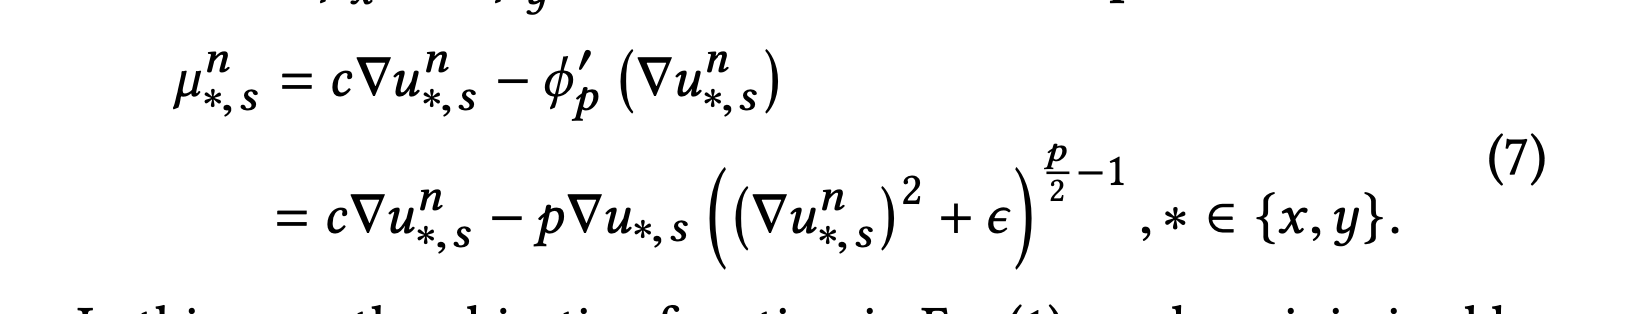

In [17]:
from IPython.display import Image
Image(filename='eq7.png') 



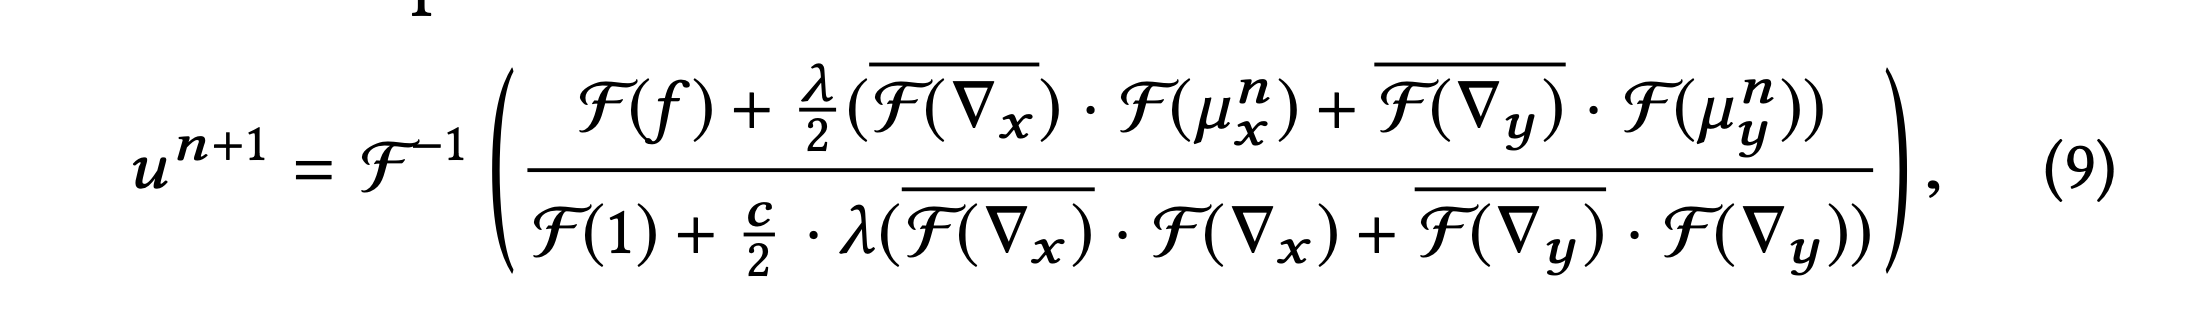

In [18]:
Image(filename='eq9.png') 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

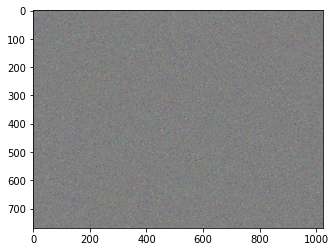

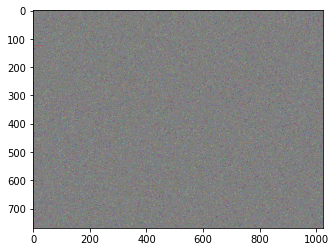

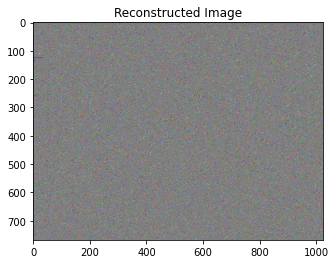

In [42]:
# print(U.shape) # (768, 1024, 3)

# print(np.diff(U, axis=2).shape) # (768, 1024, 2)
# print(np.diff(U, 1,2).shape) # (768, 1024, 2)

# print( (U[:,0,:] - U[:,-1,:]).shape) # (768, 3)
# print( (U[0,:,:] - U[-1,:,:]).shape) # (1024, 3)


for i in range(1):
    ## Step 1:  eq 7 - Intermediate variables \mu update, in x-axis and y-axis direction
    
    # Gradients delta u on x axis and delta u on y axis
    
    # image gradient in x direction
    u_extra_col = (U[:,0,:] - U[:,-1,:])[:,np.newaxis,:]
    u_extra_row = (U[0,:,:] - U[-1,:,:])[np.newaxis,:,:]
#     print(u_extra_col.shape)
#     print(u_extra_row.shape)
    
    u_h = np.hstack((np.diff(U,1,1), u_extra_col))
    u_v = np.vstack((np.diff(U,1,0), u_extra_row))
#     print(u_h.shape)
#     print(u_v.shape)
    
    mu_h = c * u_h - p * u_h * (u_h * u_h + eps)**gamma # (768, 1024, 3)
    mu_v = c * u_v - p * u_v * (u_v * u_v + eps)**gamma # (768, 1024, 3)
#     print(np.diff(mu_h,1,1).shape)
#     print(np.diff(mu_v,1,0).shape)


    ## Step 2: eq 9 - Update the smoothed image U
        # The diff causes loss in one columns
    extra_col = (mu_h[:,-1,:] - mu_h[:, 0,:])[:,np.newaxis,:]
    extra_row = (mu_v[-1,:,:] - mu_h[0,:,:])[np.newaxis,:,:]
#     print(extra_col.shape)
#     print(extra_row.shape)
    

    # we calculate the diff - the inverse first order derivative of μxn along x-axis & μyn along y-axis 
    normin2_h = np.hstack((extra_col, - np.diff(mu_h,1,1)))
    normin2_v = np.vstack((extra_row, - np.diff(mu_v,1,0)))
#     print(normin2_h.shape)
#     print(normin2_v.shape)
    plt.figure()
    plt.imshow(normin2_h)

    plt.figure()
    plt.imshow(normin2_v)
    
    numerator = (normin1 + 0.5 * lam * (fft2(mu_h + mu_v)))
    
    FU =  numerator / denominator   
    U = ifft2(FU).real
    normin1 = FU 

smoothed = U
diff = f - smoothed
image_new = f + 3 * diff

plt.figure()
plt.imshow(image_new)
plt.title('Reconstructed Image')


